In [2]:
import os, json, pickle, torch, sys
sys.path.append('../')
from src.utils.visualization import plot_scatter, read_data
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from scipy.stats import gaussian_kde

plt.rcParams['font.size'] = 13

In [3]:
def _parse_data(fn):
    with open(fn, 'rb') as f:
        ids, ts, ps = pickle.load(f)
    o = np.argsort(ids)
    r2, mae = np.array([[r2_score(t, p), mean_absolute_error(t, p)] for t, p in zip(ts.T, ps.T)]).T
    return {'r2':r2, 'mae':mae, 'id':ids[o], 't':ts[o], 'p':ps[o]}

def get_output(root, tag, fmt='cv_{:04d}', epoch='00500', dataset=['train','valid','test']):
    output = {ds:[] for ds in dataset}
    path = os.path.join(root, tag)
    if not os.path.isdir(path):
        return output
    for i in range(100):
        dn = os.path.join(path, fmt.format(i))
        for ds in dataset:
            dfn = os.path.join(dn, f'{epoch}.{ds}.pkl')
            if not os.path.isfile(dfn): 
                continue
            output[ds].append(_parse_data(dfn))
    return output

In [5]:
metric = ['R2']
root = '/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs'
nets = ['mol','graph','concat']
cv_errs = {}
fi_errs = {}
for net in nets:
    path = os.path.join(root, net)
    if not os.path.isdir(path): continue
    for tag in sorted(os.listdir(path)):
        output = get_output(path, tag, fmt='cv_{:04d}', epoch='00500')
        path_tag = os.path.join(path, tag)
        print(path_tag)
        sd = torch.load(os.path.join(path_tag, 'cv_0000/00100.model.torch'), map_location='cpu')
        n = np.sum([np.prod(v.cpu().numpy().shape) for k,v in sd.items() if k.startswith('encoder')])
        key = f'{net}_{tag}_{n}'
        cv_errs[key] = {'train':{}, 'valid':{}, 'test':{}, 'size':n,}
        fi_errs[key] = {'train':{}, 'test':{}, 'size':n}
        for ds in ['train','valid','test']:
            errs = [[output[ds][i]['r2'], output[ds][i]['mae']] for i in range(5)]
            r2, mae = np.array(errs).transpose(1, 0, 2)
            cv_errs[key][ds]['r2'] = r2
            cv_errs[key][ds]['mae'] = mae
            for s, val in zip(['R2','MAE'], [r2, mae]):
                if s not in metric: continue
                avg = np.mean(val, axis=1)
                std = np.std(val, axis=1)
                print(ds, '\t', s, '\t/ ', ' / '.join([f'{v:6.3f} ±{e:.3f}' for v, e in zip(avg, std)]))
            
            fn = os.path.join(path_tag, f'00500.{ds}.pkl')
            if not os.path.isfile(fn): continue
            out = _parse_data(fn)
            fi_errs[key][ds]['r2'] = out['r2']
            fi_errs[key][ds]['mae'] = out['mae']
            for s, e in zip(['R2','MAE'], [out['r2'], out['mae']]):
                if s not in metric: continue
                print(ds, '\t', s, '\t/ ', ' / '.join([f'{v:6.3f}       ' for v in e]))

/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs/mol/dnn_128_1
train 	 R2 	/   0.955 ±0.082 /  0.953 ±0.087 /  0.951 ±0.090 /  0.956 ±0.082 /  0.956 ±0.082
train 	 R2 	/   0.691        /  0.985        /  0.905        /  0.974        /  0.958        /  0.961        /  0.999        /  0.992        /  1.000        /  1.000        /  1.000        /  1.000       
valid 	 R2 	/   0.947 ±0.096 /  0.947 ±0.091 /  0.947 ±0.100 /  0.951 ±0.092 /  0.949 ±0.093
test 	 R2 	/   0.953 ±0.088 /  0.952 ±0.091 /  0.949 ±0.096 /  0.953 ±0.089 /  0.952 ±0.090
test 	 R2 	/   0.681        /  0.988        /  0.901        /  0.971        /  0.956        /  0.964        /  0.999        /  0.993        /  1.000        /  1.000        /  1.000        /  1.000       
/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs/mol/dnn_128_2
train 	 R2 	/   0.960 ±0.075 /  0.959 ±0.077 /  0.961 ±0.072 /  0.960 ±0.075 /  0.958 ±0.077
train 	 R2 	/   0.727        /  0.986        /  0.918        /  0.977        /  0.96

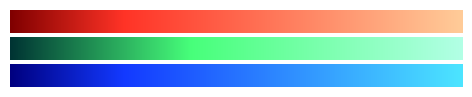

In [6]:
cmap1 = lambda x: [np.min([x*2+0.5,1]), x*0.8, x*0.6]
cmap2 = lambda x: [x*0.7, np.min([x*2+0.2,1]), np.min([x*0.7+0.2, 1])]
cmap3 = lambda x: [x*0.3, x*0.9, np.min([x*2+0.5, 1])]
f, axs = plt.subplots(3,1,figsize=(10,1))
for ax, cmap in zip(axs, [cmap1, cmap2, cmap3]): 
    ax.imshow([[cmap(x) for x in np.linspace(0,1,500)]], extent=[0,200,0,10])
    ax.axis('off')

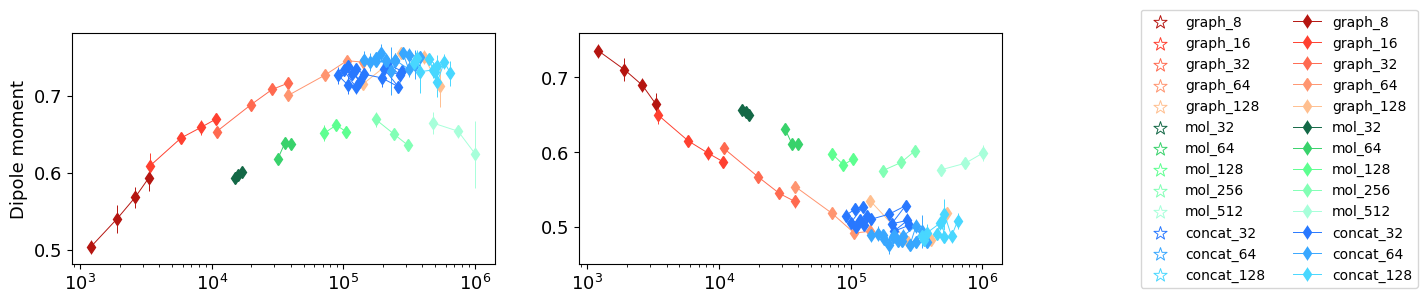

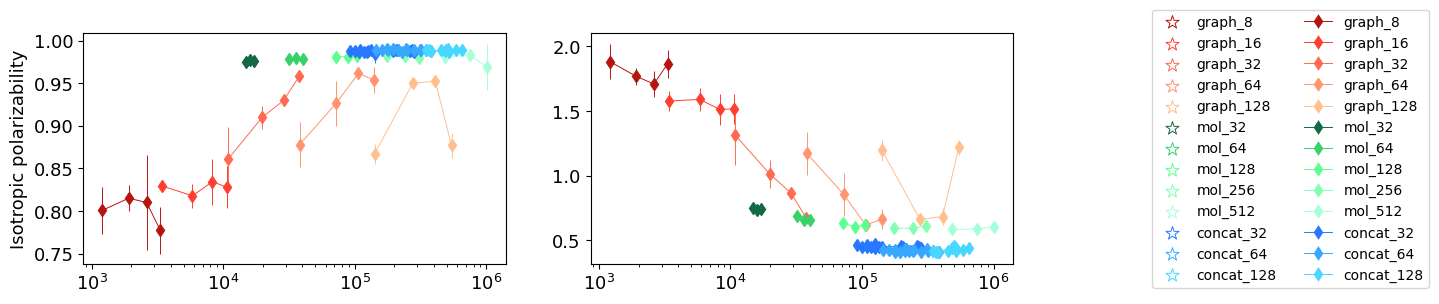

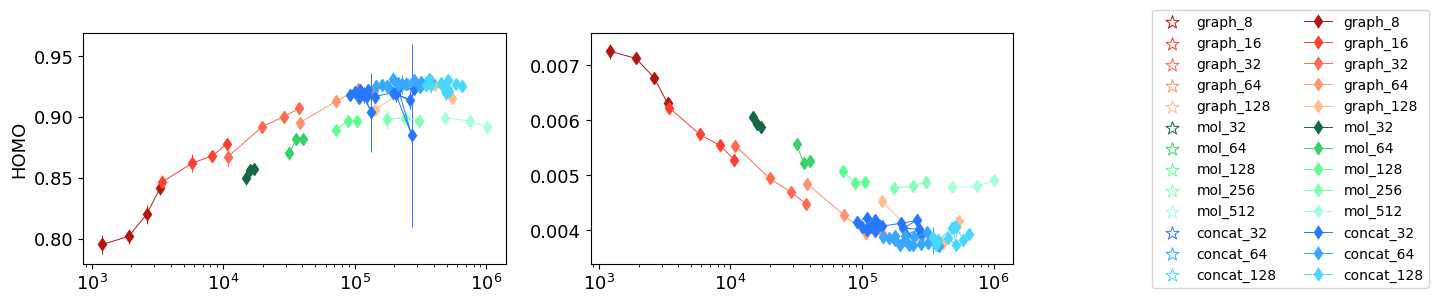

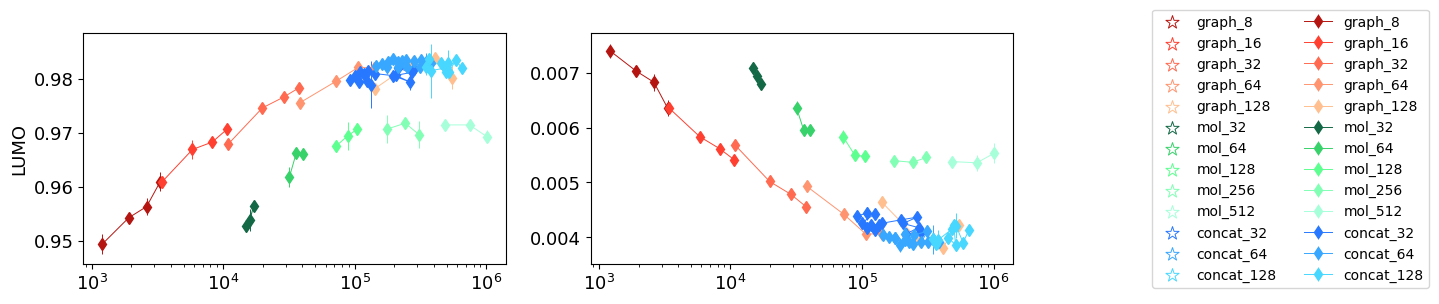

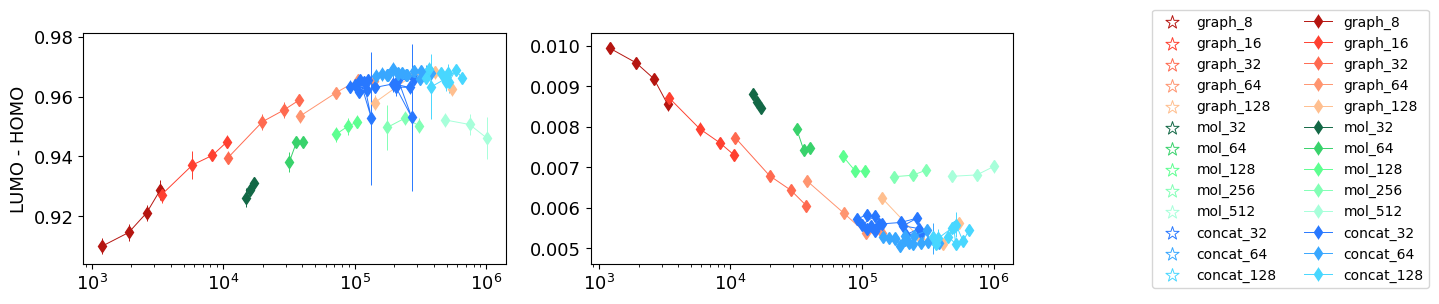

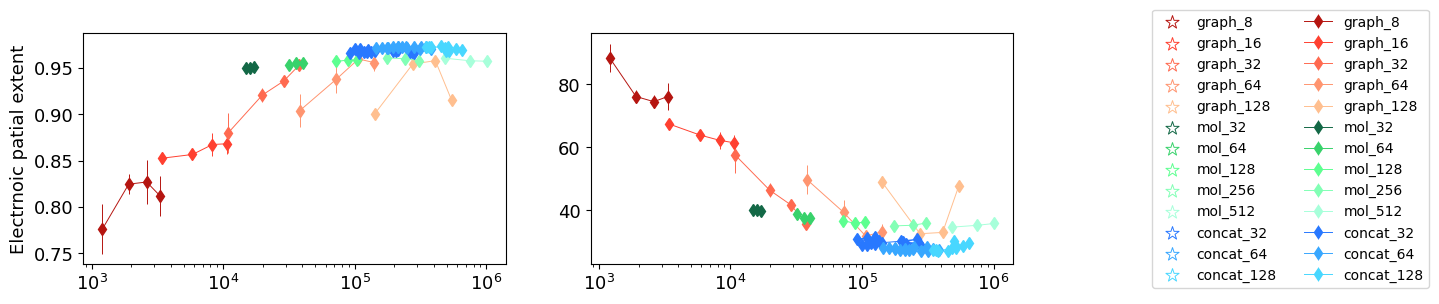

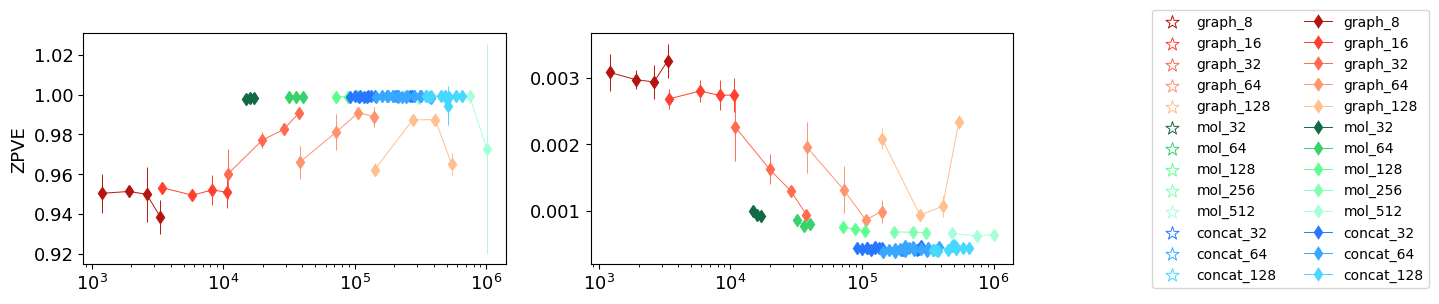

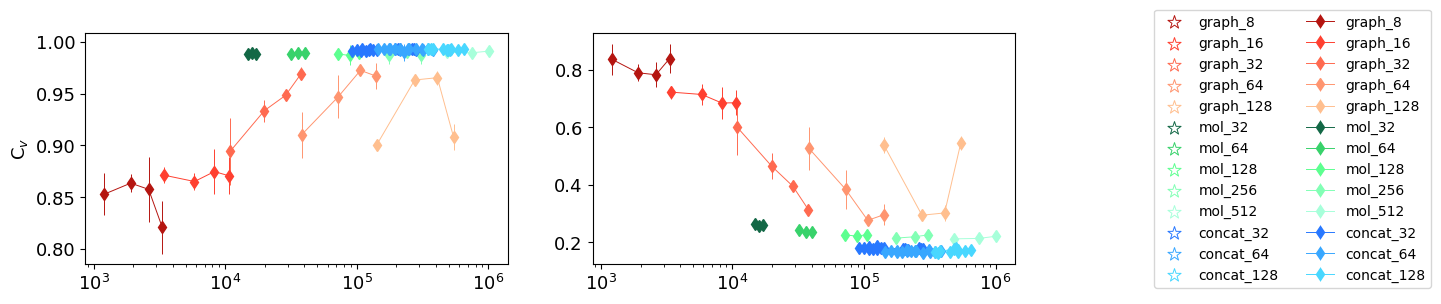

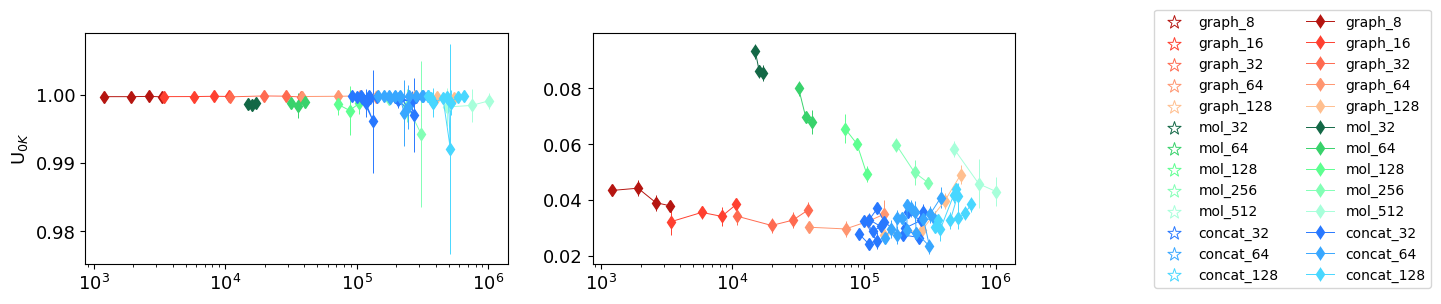

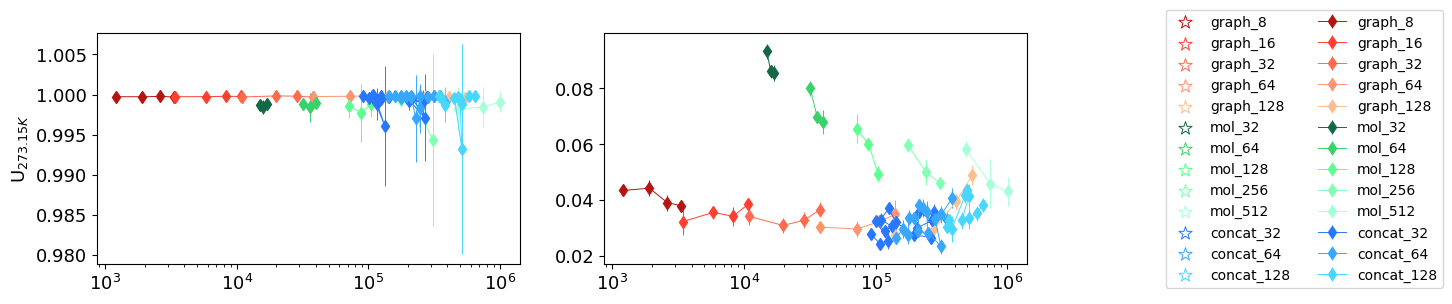

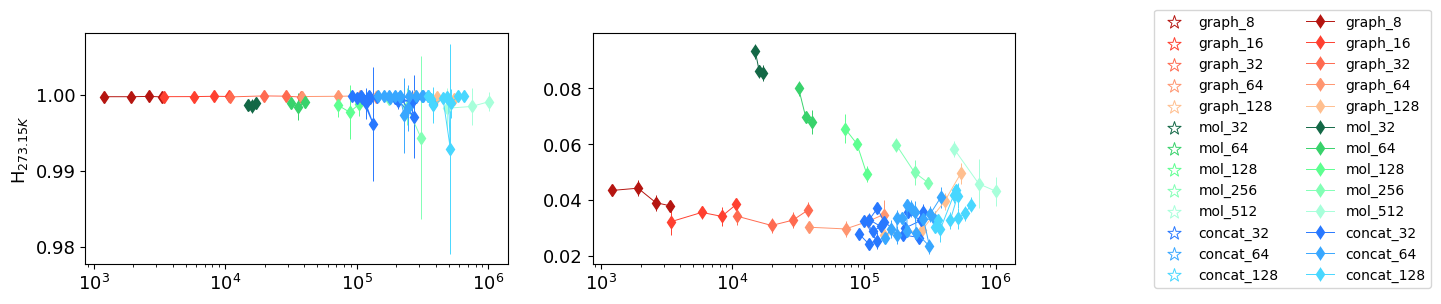

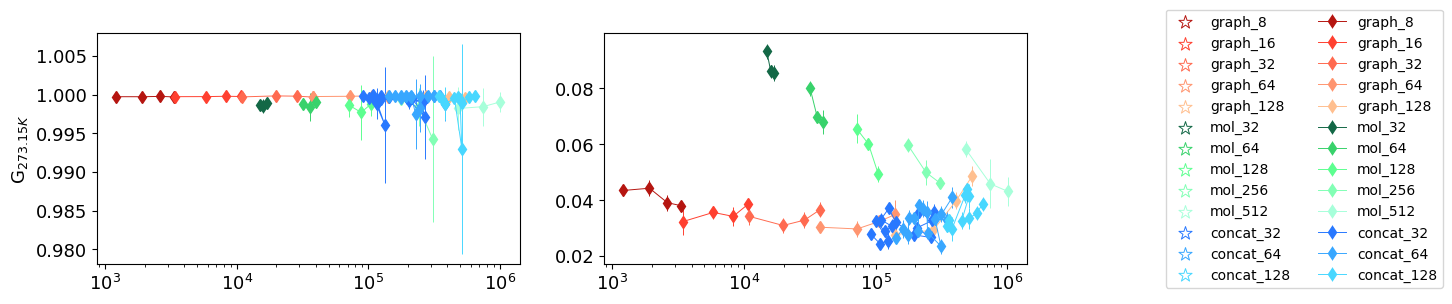

In [80]:
xlbl = ["Dipole moment","Isotropic polarizability","HOMO","LUMO","LUMO - HOMO","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
metrics = ['r2','mae']
by_node = True
by_graph = True
figs = {lbl:plt.subplots(1,len(metrics),figsize=(12,3)) for lbl in xlbl}
for ds in ['valid']:
    for i, metric in enumerate(metrics):
        err = [v[ds][metric] for v in cv_errs.values()]
        lbls = list(cv_errs.keys())
        x = np.array([v['size'] for v in cv_errs.values()])
        y_vals = np.mean(err, 1)
        y_errs = np.std(err, 1)
        group = np.array([l.split('_')[3-int(by_node)].split('.')[int(by_graph)-1] for l in lbls]).astype(float)
        for j, (y_val, y_err) in enumerate(zip(y_vals.T, y_errs.T)):
            for net in ['graph','mol','concat']:
                if net == 'graph':
                    cmap = lambda x: cmap1((x-3+0.5)/4.8) if by_node else cmap1((x-2+0.5)/6.8)
                elif net == 'mol':
                    cmap = lambda x: cmap2((x-5+0.5)/4.8) if by_node else cmap2((x-1+0.5)/2.8)
                else:
                    if by_graph:
                        cmap = lambda x: cmap3((x-3+0.5)/4.8) if by_node else cmap3((x-2+0.5)/6.8)
                    else:
                        cmap = lambda x: cmap3((x-5+0.5)/4.8) if by_node else cmap3((x-1+0.5)/2.8)
                for n in range(1,10):
                    p = 2 ** n if by_node else n
                    mask = np.array([l.startswith(net) and int(g) == p for l,g in zip(lbls, group)])
                    mask = mask & np.array(['old' not in l for l in lbls])
                    if np.sum(mask) == 0: continue
#                    print(net, p, n, cmap(n))
                    figs[xlbl[j]][1][i].errorbar(x[mask], y=y_val[mask], lw=0.7, fmt='--' if ds =='train' else '-', yerr=y_err[mask], marker='s' if ds == 'train' else 'd', color=cmap(n), label=f'{net}_{p}')

                    mask = np.array([l.startswith(net) and 'old' in l for l in lbls])
                    figs[xlbl[j]][1][i].scatter(x[mask], y=y_val[mask], lw=0.7, marker='*', facecolor=[1,1,1], edgecolor=cmap(n), label=f'{net}_{p}', s=100)

for lbl, (f, ax) in figs.items():
    ax[0].set_ylabel(lbl)
    ax[-1].legend(loc='center right', bbox_to_anchor=[2, 0.5], fontsize=10, ncol=2)
    for _ax in ax:
#        _ax.set_xlim([8e2, 2e6])
        _ax.set_xscale('log')


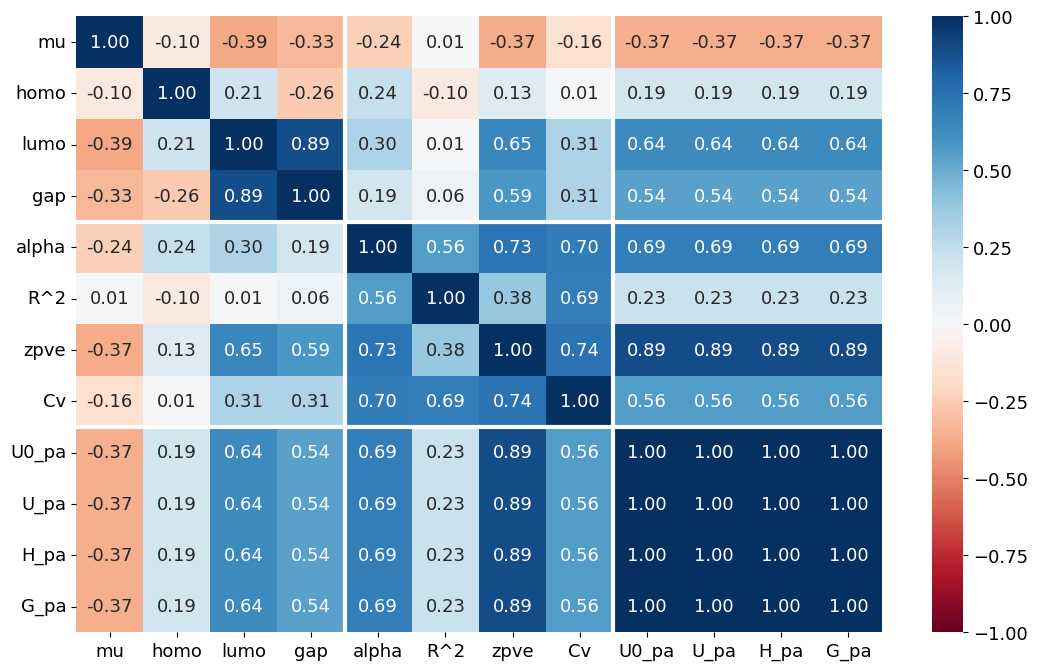

In [83]:
import seaborn as sns

df = pd.read_csv('/home/jhyang/WORKSPACES/DATA/molecule/qm9/qm9.csv')
cols = ['mu', 'homo', 'lumo', 'gap', 'alpha', 'R^2', 'zpve', 'Cv', 'U0_pa', 'U_pa', 'H_pa', 'G_pa']
f, ax = plt.subplots(1,1,figsize=(13,8))
sns.heatmap(df[cols].corr().values, ax=ax, vmin=-1, vmax=1, cmap='RdBu', annot=True, fmt='.2f')
_ = ax.set_xticklabels(cols)
_ = ax.set_yticklabels(cols, rotation=0)
for i in [4, 8]:
    ax.axvline(i, color=[1,1,1], lw=3)
    ax.axhline(i, color=[1,1,1], lw=3)

G$_{273.15K}$


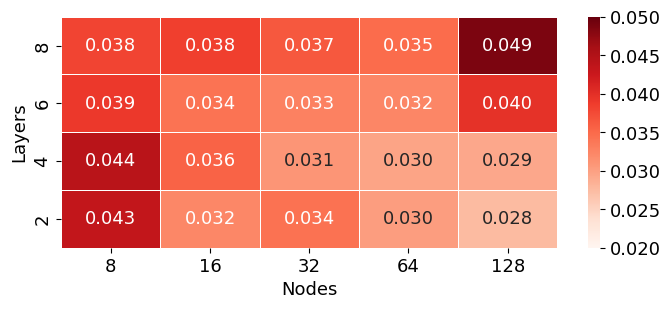

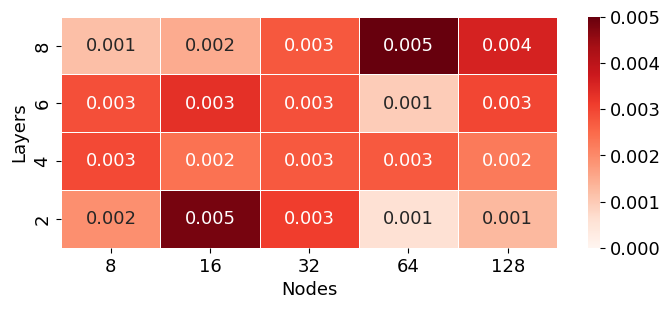

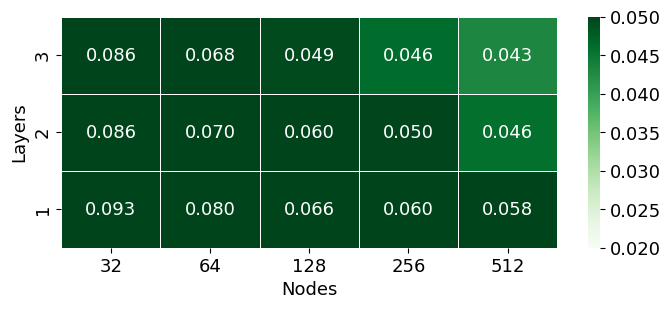

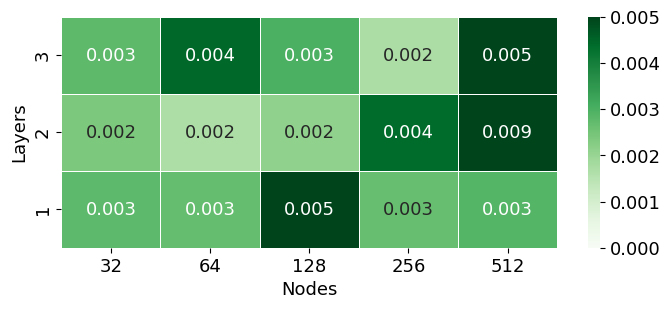

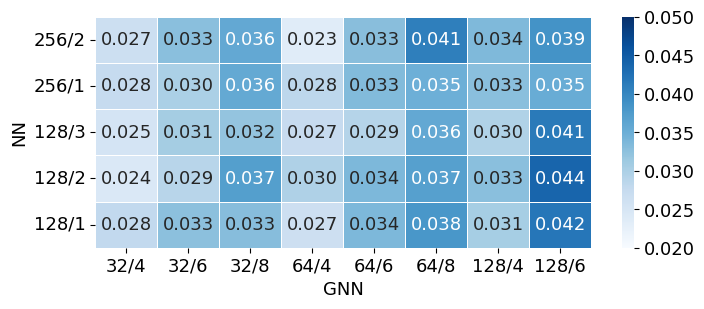

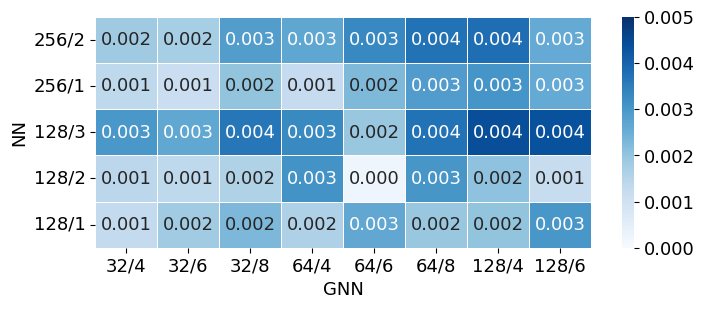

In [98]:
metric = 'mae'
vals = np.array([np.mean(v['valid'][metric], 0) for v in cv_errs.values()])
errs = np.array([np.std(v['valid'][metric], 0) for v in cv_errs.values()])
xlbls = ["Dipole moment","Isotropic polarizability","HOMO","LUMO","LUMO - HOMO","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
lbls = list(cv_errs.keys())
nets = [l.split('_')[0] for l in lbls]
nodes = [int(l.split('_')[2]) if not l.startswith('concat') else 0 for l in lbls]
layers = [int(l.split('_')[3]) if not l.startswith('concat') else 0 for l in lbls]
cnodes = ['/'.join(np.array(l.replace('.','_').split('_'))[[2,4]]) if l.startswith('concat') else '' for l in lbls]
clayers = ['/'.join(np.array(l.replace('.','_').split('_'))[[3,5]]) if l.startswith('concat') else '' for l in lbls]
df_dict = {'Network':nets, 'Nodes':nodes, 'Layers':layers, 'GNN':cnodes, 'NN':clayers}
df_dict.update({f'{k}/avg':v for k,v in zip(xlbls, vals.T)})
df_dict.update({f'{k}/std':v for k,v in zip(xlbls, errs.T)})
mdf = pd.DataFrame(df_dict)
cdf = mdf[mdf.Network == 'concat']

vmins = 0.02, 0.0
vmaxs = 0.05, 0.005
for xlb in xlbls:
    if not xlb.startswith('G'): continue
    print(xlb)
    for net, cmap in zip(['graph','mol','concat'], ['Reds','Greens','Blues']):
        for tgt, vmin, vmax in zip(['avg','std'], vmins, vmaxs):
            f, ax = plt.subplots(1, 1, figsize=(8, 3))
            if net =='concat':
                cdf_p = pd.pivot(cdf, index='NN', columns='GNN', values=f'{xlb}/{tgt}').T.sort_index(key=lambda x: x.map(lambda x: float(x.split('/')[0]))).T
                sns.heatmap(cdf_p, vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt='.3f', linewidth=0.5, ax=ax)       
            else:
                sns.heatmap(pd.pivot(mdf[mdf.Network == net], index='Layers', columns='Nodes', values=f'{xlb}/{tgt}'), 
                            vmin=vmin, vmax=vmax, cmap=cmap, annot=True, fmt='.3f', linewidth=0.5, ax=ax)       
            ax.invert_yaxis()

In [103]:
vals

array(<generator object <genexpr> at 0x7f44bfe8e740>, dtype=object)

(800.0, 2000000.0)

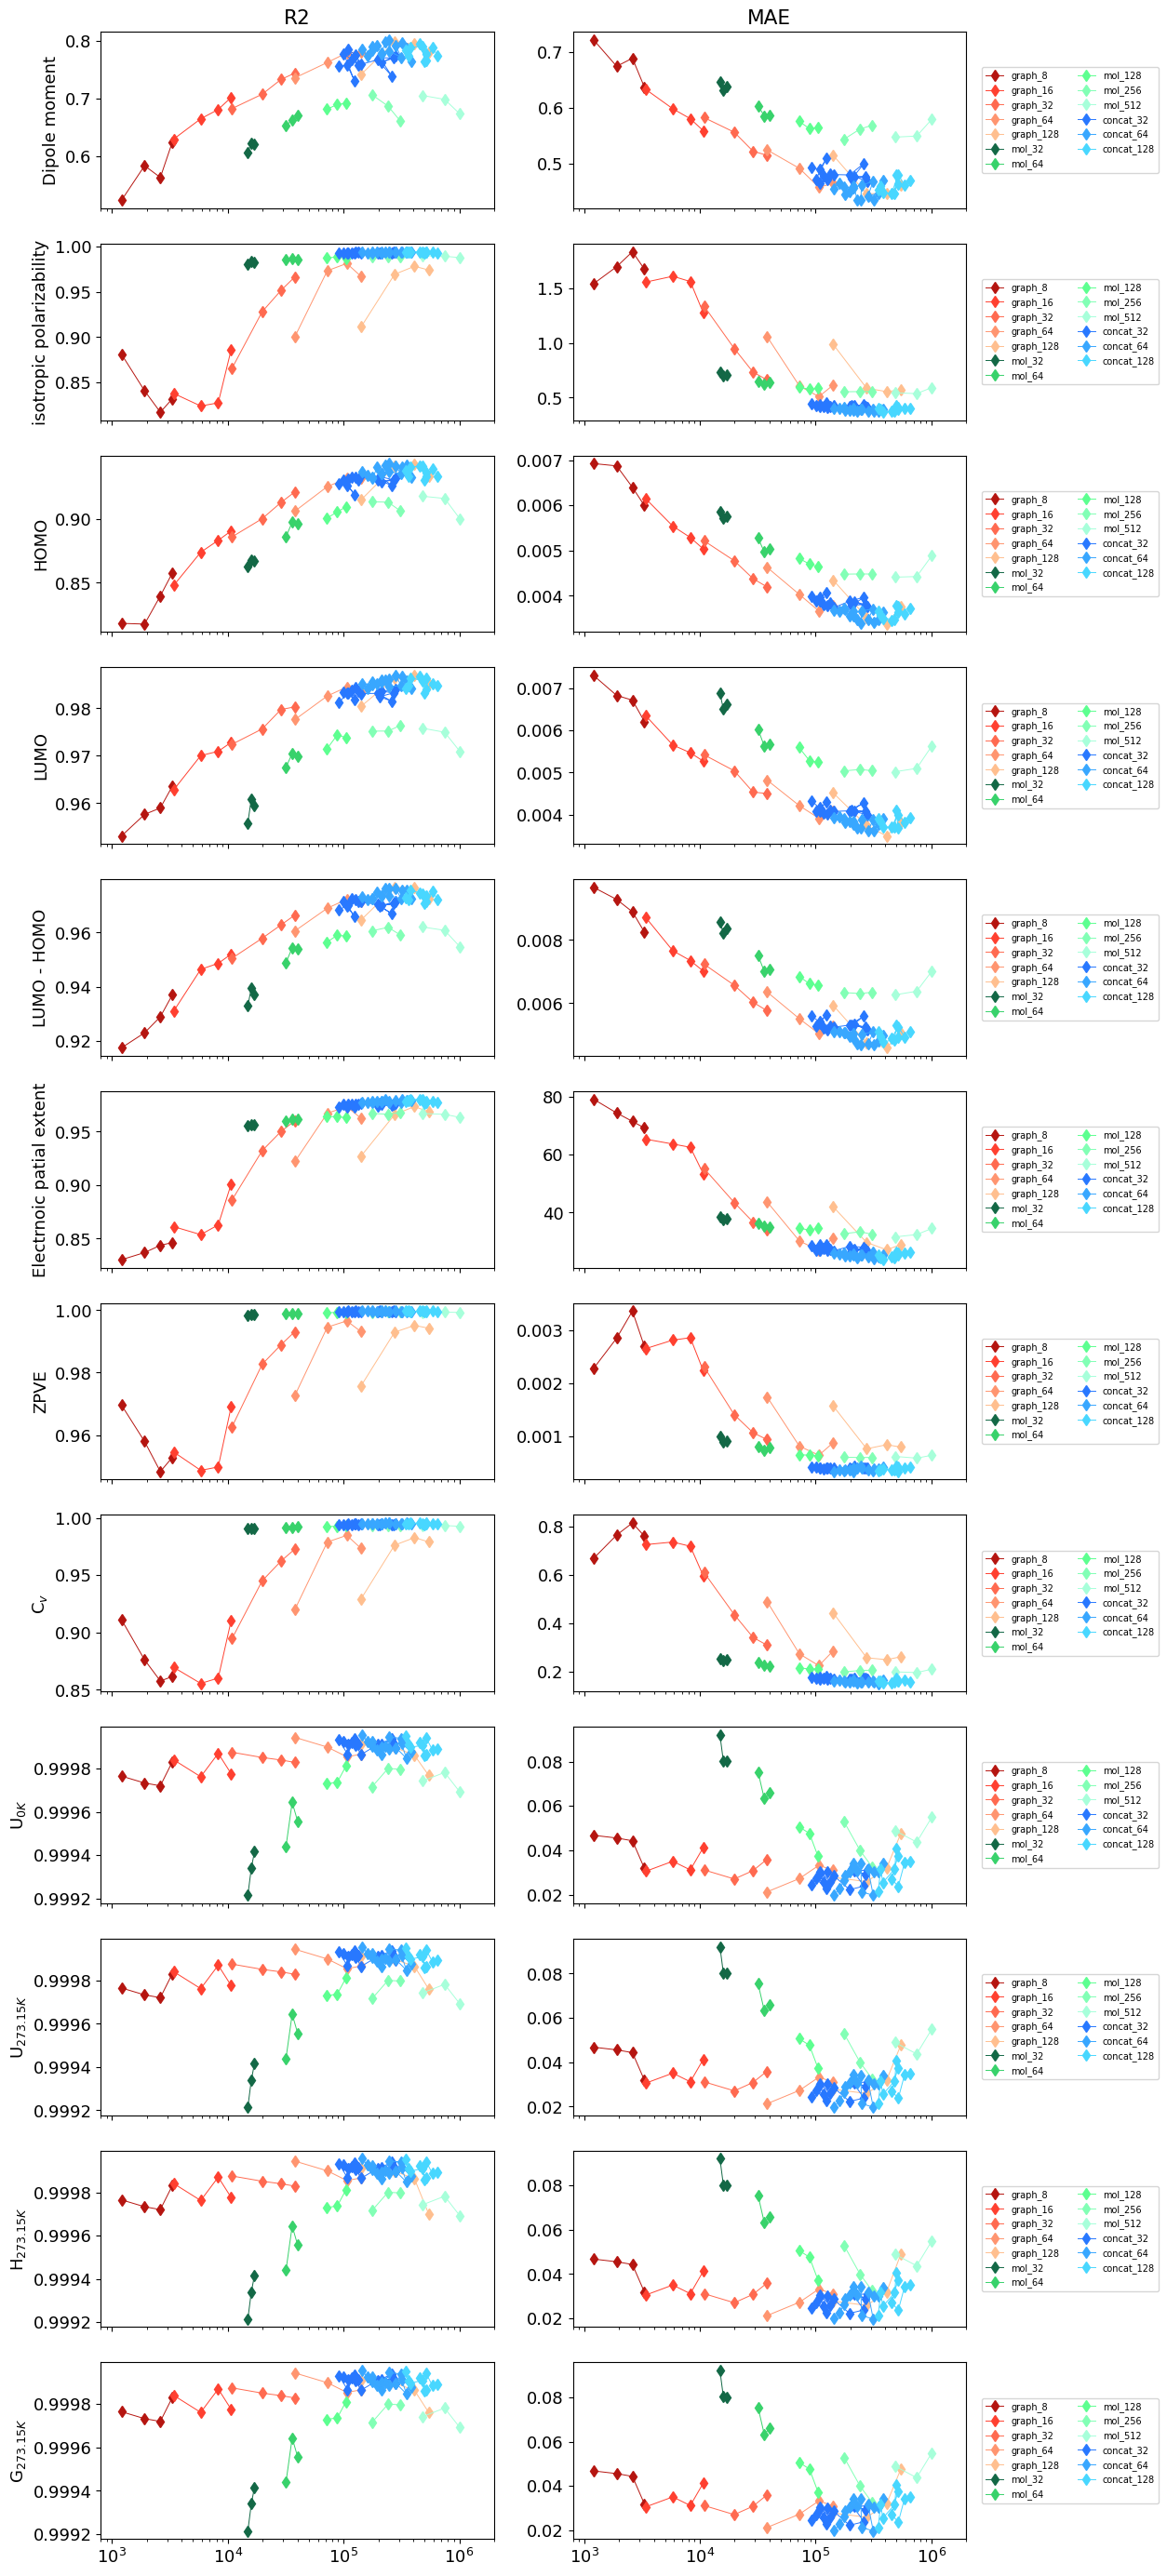

In [105]:
xlbls = ["Dipole moment","isotropic polarizability","HOMO","LUMO","LUMO - HOMO","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
f, axs = plt.subplots(12,2,figsize=(12,35), sharex=True)
metrics = ['r2','mae']
by_node = True
by_graph = True
for i, metric in enumerate(metrics):
    for ds in ['test']:
        vals = np.array([v[ds][metric] for v in fi_errs.values()])
        lbls = fi_errs.keys()
        x = np.array([float(l.split('_')[4]) for l in lbls])
        group = np.array([l.split('_')[3-int(by_node)].split('.')[int(by_graph)-1] for l in lbls]).astype(float)
        for j, val in enumerate(vals.T):
            for net in ['graph','mol','concat']:
                if net == 'graph':
                    cmap = lambda x: cmap1((x-3+0.5)/4.8) if by_node else cmap1((x-2+0.5)/6.8)
                elif net == 'mol':
                    cmap = lambda x: cmap2((x-5+0.5)/4.8) if by_node else cmap2((x-1+0.5)/2.8)
                else:
                    if by_graph:
                        cmap = lambda x: cmap3((x-3+0.5)/4.8) if by_node else cmap3((x-2+0.5)/6.8)
                    else:
                        cmap = lambda x: cmap3((x-5+0.5)/4.8) if by_node else cmap3((x-1+0.5)/2.8)
                for nl in range(1,10):
                    p = 2 ** nl if by_node else nl
                    mask = np.array([l.startswith(net) and int(g) == p for l,g in zip(lbls, group)])
                    if np.sum(mask) == 0: continue
#                    print(net, p, nl, cmap(nl), x.shape, mask.shape, val.shape)
                    axs[j, i].errorbar(x[mask], y=val[mask], lw=0.7, fmt='--' if ds =='train' else '-', 
                                       yerr=np.zeros_like(x[mask]), marker='s' if ds == 'train' else 'd', color=cmap(nl), label=f'{net}_{p}')


for ax, lbl in zip(axs, xlbls):
    ax[1].legend(loc='center right', bbox_to_anchor=[1.5, 0.5], ncol=2, fontsize=7)
    ax[0].set_ylabel(lbl)
axs[0,0].set_title('R2')
axs[0,1].set_title('MAE')
axs[-1,-1].set_xscale('log')
axs[0,0].set_xlim([8e2, 2e6])
#axs[-1,1].set_xticks(list(range(len(xlbl))), labels=xlbl)

In [141]:
errs = [v['valid'][metric] for v in cv_errs.values()]
np.array(errs).shape

(75, 5, 12)

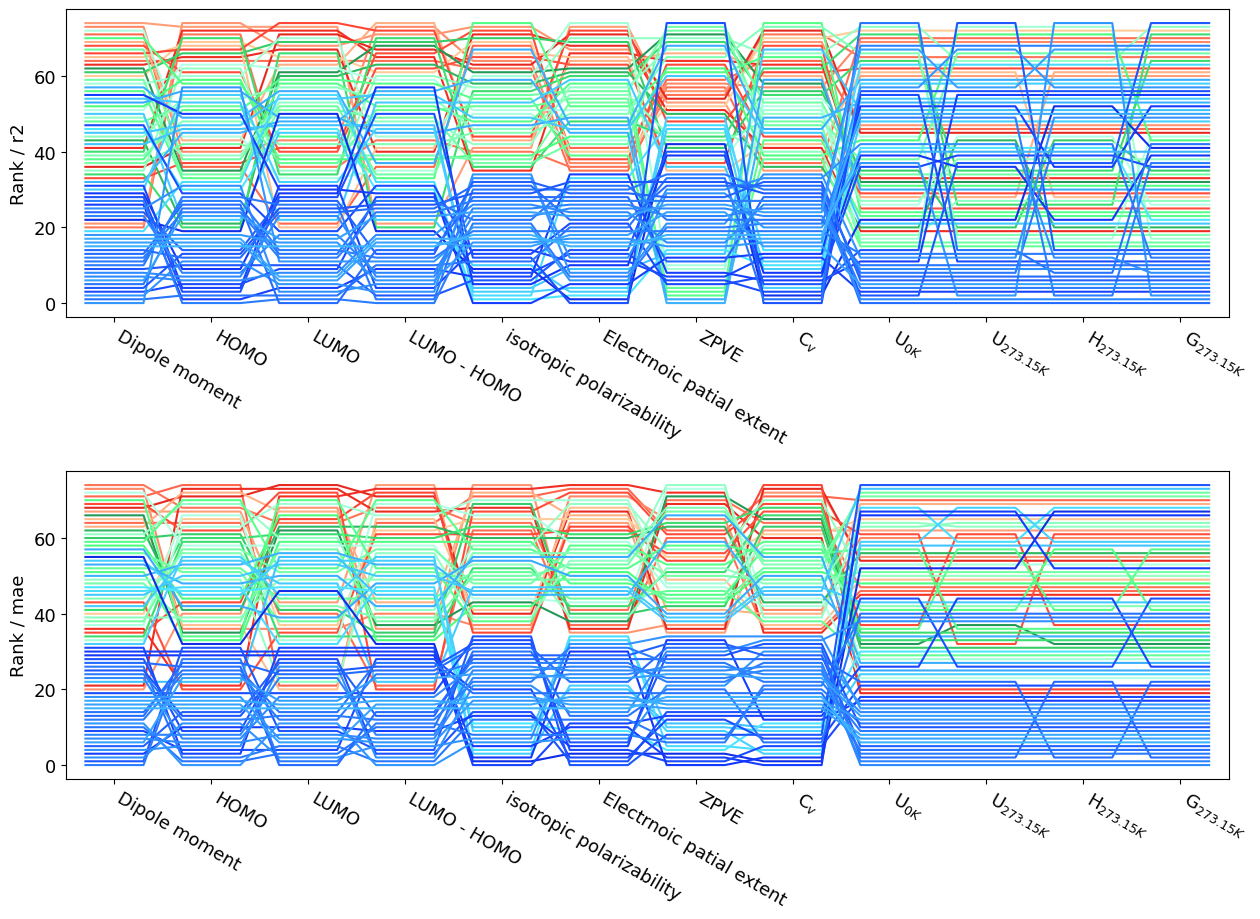

In [144]:
xlbls = ["Dipole moment","HOMO","LUMO","LUMO - HOMO","isotropic polarizability","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
f, axs = plt.subplots(2,1,figsize=(15,10))

for i, metric in enumerate(['r2','mae']):
    errs = [v['valid'][metric] for v in cv_errs.values()]
    lbls = list(cv_errs.keys())
    size = [v['size'] for v in cv_errs.values()]
    ys = np.mean(errs, 1)
    ranks = np.argsort(ys, axis=0) if metric != 'r2' else np.argsort(ys, axis=0)[::-1]
    ranks = np.hstack([ranks[:,0:1], ranks[:, 2:5], ranks[:, 1:2], ranks[:,5:]])
    x = np.hstack([[i-0.3, i+0.3] for i in range(ys.shape[1])])
    minmax = {m[0]:[np.min([s for s, l in zip(size, lbls) if l.startswith(m)]), np.max([s for s, l in zip(size, lbls) if l.startswith(m)])] for m in ['mol','graph','concat']}
    for y, l, s in zip(ranks, lbls, size):
        yy = np.hstack([[_y, _y] for _y in y])
        vmin, vmax = minmax[l[0]]
        scale = 0.8 * (np.log10(s) - np.log10(vmin))/(np.log10(vmax)  - np.log10(vmin)) + 0.2
        if l.startswith('mol'):
            axs[i].plot(x, yy, label='Global state', color=cmap1(scale))
        elif l.startswith('graph'):
            axs[i].plot(x, yy, label='Graph feature', color=cmap2(scale))
        elif l.startswith('concat'):
            axs[i].plot(x, yy, label='Mixed', color=cmap3(scale))
    axs[i].set_xticks(list(range(len(xlbl))), labels=xlbls, rotation=-30, ha='left')
    axs[i].set_xlim([-0.5, 11.5])
    axs[i].set_ylabel(f'Rank / {metric}')
f.subplots_adjust(hspace=0.5)

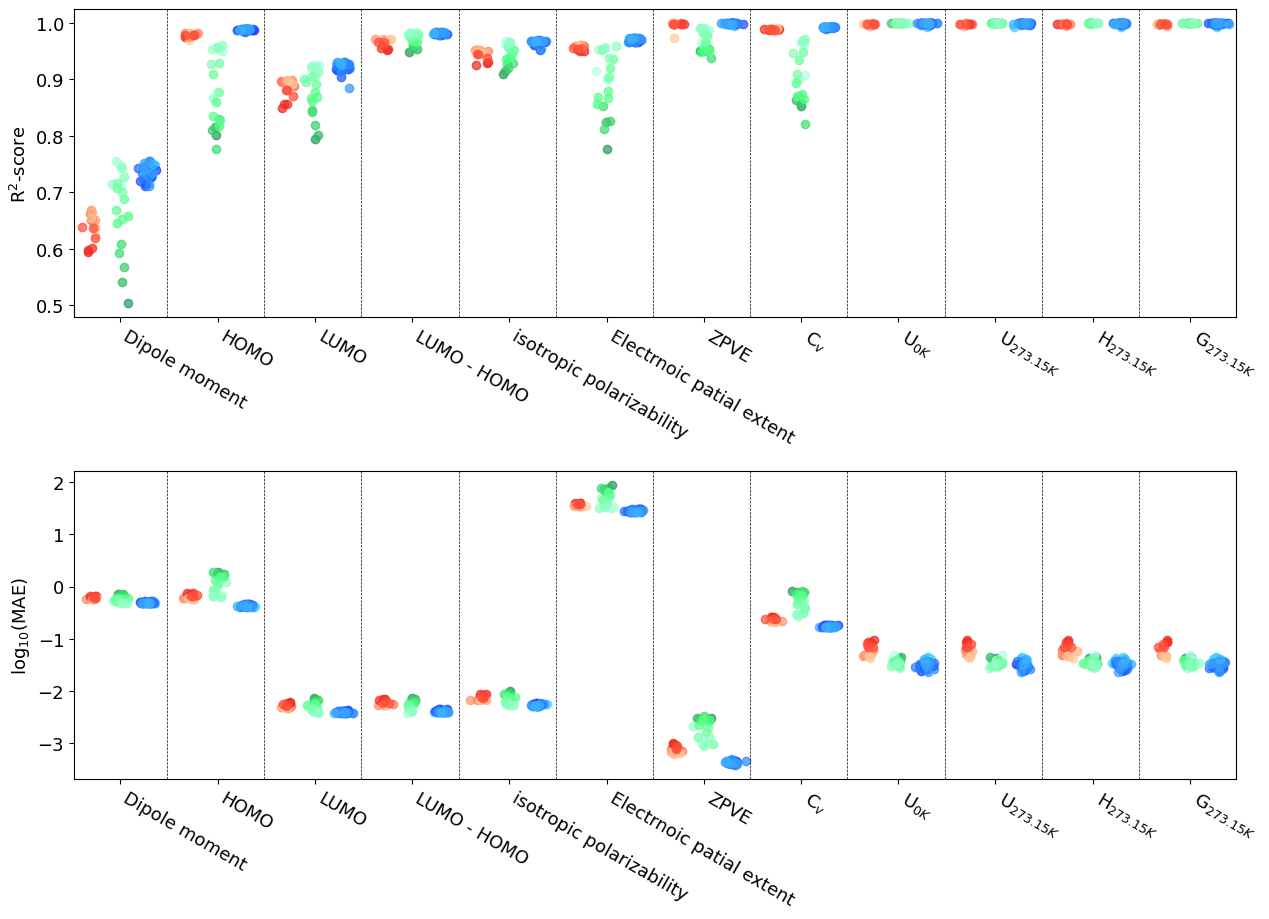

In [145]:
xlbls = ["Dipole moment","HOMO","LUMO","LUMO - HOMO","isotropic polarizability","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
f, axs = plt.subplots(2,1,figsize=(15,10))
for i, metric in enumerate(['r2','mae']):
    errs = [v['valid'][metric] for v in cv_errs.values()]
    lbls = list(cv_errs.keys())
    size = [v['size'] for v in cv_errs.values()]
    ys = np.mean(errs, 1)
    x = np.linspace(0, 23, 12)
    minmax = {m[0]:[np.min([s for s, l in zip(size, lbls) if l.startswith(m)]), np.max([s for s, l in zip(size, lbls) if l.startswith(m)])] for m in ['graph','mol','concat']}
    for y, l, s in zip(ys, lbls, size):
        vmin, vmax = minmax[l[0]]
        scale = 0.8 * (np.log10(s) - np.log10(vmin))/(np.log10(vmax)  - np.log10(vmin)) + 0.2
        if l.startswith('mol'):
            axs[i].scatter(x-0.6+np.random.normal(0,0.08,x.shape), y if i == 0 else np.log10(y), label='Global state', color=cmap1(scale), alpha=0.7)
        elif l.startswith('graph'):
            axs[i].scatter(x+np.random.normal(0,0.08,x.shape), y if i == 0 else np.log10(y), label='Graph feature', color=cmap2(scale), alpha=0.7)
        elif l.startswith('concat'):
            axs[i].scatter(x+0.6+np.random.normal(0,0.08,x.shape), y if i == 0 else np.log10(y), label='Mixed', color=cmap3(scale), alpha=0.7)
    axs[i].set_xticks(x, labels=xlbls, rotation=-30, ha='left')
    axs[i].set_xlim([-1, 24])
    axs[i].set_ylabel('R$^2$-score' if i == 0 else 'log$_{10}$'+f'({metric.upper()})')
    for ix in x: axs[i].axvline(ix+1, color=[0,0,0], lw=0.5, ls='--')
f.subplots_adjust(hspace=0.5)

In [8]:
xlbls = ["Dipole moment","HOMO","LUMO","LUMO - HOMO","isotropic polarizability","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]

r2s = np.mean([v['valid']['r2'] for v in cv_errs.values()], 1)
maes = np.mean([v['valid']['mae'] for v in cv_errs.values()], 1)
lbls = list(cv_errs.keys())
#score_r2  = np.sum((r2s - r2s.min(axis=0))/(r2s.max(axis=0) - r2s.min(axis=0)), axis=1)
#score_mae = np.sum((maes - maes.min(axis=0))/(maes.max(axis=0) - maes.min(axis=0)), axis=1)
score_r2  = np.sum(r2s/r2s.max(axis=0), axis=1)
score_mae = np.sum(maes/maes.min(axis=0), axis=1)

rank_mae = score_mae.argsort().argsort()
rank_r2 = score_r2.shape[0] - score_r2.argsort().argsort() - 1
data = {
    'mae/rank':rank_mae, 'mae/score':score_mae, 'r2/rank':rank_r2, 'r2/score':score_r2,
}
data.update({f'mae/{xlb}':v for xlb, v in zip(xlbls, np.array(maes).T)})
data.update({f'r2/{xlb}':v for xlb, v in zip(xlbls, np.array(r2s).T)})
data.update({f'mae/rank/{xlb}':np.argsort(v).argsort() for xlb, v in zip(xlbls, np.array(maes).T)})
data.update({f'r2/rank/{xlb}':score_r2.shape[0] - np.argsort(v).argsort() - 1 for xlb, v in zip(xlbls, np.array(r2s).T)})
data.update({
    'graph/node' :[int(l.split('_')[2].split('.')[0]) if not l.startswith('mol') else 0 for l in lbls],
    'graph/layer':[int(l.split('_')[3].split('.')[0]) if not l.startswith('mol') else 0 for l in lbls],
    'mol/node' :[int(l.split('_')[2].split('.')[-1]) if not l.startswith('graph') else 0 for l in lbls],
    'mol/layer':[int(l.split('_')[3].split('.')[-1]) if not l.startswith('graph') else 0 for l in lbls],
    'global/param':[int(float(l.split('_')[4])) for l in lbls],
    'global/label':lbls,
    
    })
df = pd.DataFrame(data)
scores = df[['r2/score','mae/score']].values
norm = (scores - scores.min(axis=0)) / (scores.max(axis=0) - scores.min(axis=0))
df['global/score'] = norm.T[1] - norm.T[0]
df['global/rank'] = np.argsort(norm.T[1] - norm.T[0]).argsort()

pd.set_option('display.max_colwidth', 12)
#df.sort_values('r2/rank')[:20]['global/label'].values
#df.sort_values('mae/rank')[:20]['global/label'].values
#df.sort_values('global/rank')[:20]['global/label'].values

In [9]:
#df[(df['graph/node'] == 64) & (df['graph/layer'] == 4)].T
#df[df['graph/node' == 0]].sort_values('mae/rank').T
#df[df['mol/node' == 0]].sort_values('mae/rank').T
#df[df['mol/layer'] == 0].sort_values('r2/rank').T
df.sort_values('mae/rank').T
df.sort_values('r2/rank').T

,64,71,73,36,41,74,63,65,69,66,...,31,27,26,25,24,23,17,18,16,15
mae/rank,19,15,22,13,17,36,21,4,3,34,...,58,61,67,66,69,68,71,72,73,74
mae/score,13.91736,13.83806,14.180368,13.714282,13.858632,15.283484,14.102486,13.194146,13.186495,15.063875,...,23.30961,26.546616,29.44619,28.927957,29.980224,29.746291,32.96937,33.9775,34.462869,35.883448
r2/rank,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
r2/score,11.997142,11.995725,11.987998,11.986481,11.979842,11.977692,11.976799,11.976781,11.974428,11.973579,...,11.560069,11.381634,11.34501,11.324223,11.254653,11.191256,11.034662,11.007027,10.979584,10.839423
mae/Dipole moment,0.475961,0.475874,0.479459,0.482902,0.490425,0.479185,0.483292,0.486359,0.487474,0.488712,...,0.553741,0.605068,0.587342,0.598637,0.615086,0.650402,0.689548,0.66405,0.710369,0.735758
mae/HOMO,0.413212,0.410204,0.416322,0.414056,0.418088,0.414038,0.426745,0.418465,0.42421,0.434925,...,1.172235,1.313561,1.517283,1.513143,1.590185,1.577986,1.709157,1.864771,1.769642,1.883434
mae/LUMO,0.003726,0.003742,0.00376,0.003734,0.003856,0.003721,0.003887,0.003815,0.003878,0.003888,...,0.00485,0.005537,0.005285,0.005547,0.005745,0.006234,0.00678,0.006316,0.007128,0.00726
mae/LUMO - HOMO,0.003865,0.003919,0.003916,0.003886,0.003995,0.003913,0.003989,0.003957,0.004044,0.004068,...,0.004927,0.005676,0.005411,0.005615,0.005833,0.006355,0.006824,0.006358,0.00703,0.0074
mae/isotropic polarizability,0.00507,0.005142,0.005147,0.005113,0.005291,0.005128,0.005255,0.005212,0.005305,0.005304,...,0.006666,0.007728,0.007297,0.007607,0.007949,0.008715,0.009184,0.008558,0.009579,0.009938
mae/Electrnoic patial extent,27.29936,27.207461,26.995854,27.385069,27.13914,27.436078,27.830461,27.697638,28.251766,27.462115,...,49.768333,57.50816,61.413641,62.213191,63.913074,67.406758,74.489651,76.097499,76.122621,88.349214


In [149]:
maes = np.mean([v['valid']['mae'] for v in cv_errs.values()], axis=1)
r2s = np.mean([v['valid']['r2'] for v in cv_errs.values()], axis=1)
err_maes = np.std([v['valid']['mae'] for v in cv_errs.values()], axis=1)
err_r2s = np.std([v['valid']['r2'] for v in cv_errs.values()], axis=1)
i1 = 64
i2 = 70
fps = ['{:.4f}', '{:.4f}', '{:.6f}', '{:.6f}', '{:.6f}', '{:.2f}', '{:.7f}', '{:.4f}', '{:.5f}', '{:.5f}', '{:.5f}', '{:.5f}',]
for xlbl, mae, mae_err, r2, r2_err, fp in zip(xlbls, maes.T, err_maes.T, r2s.T, err_r2s.T, fps):
    i3 = np.argmin(mae)
    i4 = np.argmax(r2)
    fmt = '{:25s} /' + '//'.join([fp + '±' + fp + '/{:.4f}±{:.4f}']*3)
    #print('{:25s} / {:12.3f}±{:.3f} / {:.4f}±{:.4f} // {}±{} / {:.4f}±{:.4f} // {}±{} / {:.4f}±{:.4f}'.format(
    print(fmt.format(
        xlbl, mae[i1], mae_err[i1], r2[i1], r2_err[i1],
        mae[i2], mae_err[i2], r2[i2], r2_err[i2],
        mae[i3], mae_err[i3], r2[i4], r2_err[i4],
        ))

Dipole moment             /0.4760±0.0118/0.7559±0.0121//0.5010±0.0095/0.7349±0.0103//0.4759±0.0047/0.7565±0.0052
HOMO                      /0.4132±0.0138/0.9896±0.0039//0.4344±0.0104/0.9888±0.0039//0.4102±0.0079/0.9898±0.0036
LUMO                      /0.003726±0.000096/0.9314±0.0052//0.003961±0.000078/0.9243±0.0044//0.003721±0.000053/0.9316±0.0033
LUMO - HOMO               /0.003865±0.000124/0.9837±0.0008//0.004112±0.000072/0.9822±0.0008//0.003815±0.000046/0.9839±0.0005
isotropic polarizability  /0.005070±0.000172/0.9692±0.0025//0.005448±0.000086/0.9660±0.0020//0.005070±0.000172/0.9694±0.0021
Electrnoic patial extent  /27.30±0.40/0.9727±0.0008//28.50±0.86/0.9710±0.0011//27.00±0.77/0.9732±0.0011
ZPVE                      /0.0004330±0.0000206/0.9994±0.0004//0.0003951±0.0000167/0.9992±0.0007//0.0003777±0.0000204/0.9995±0.0000
C$_v$                     /0.1662±0.0037/0.9936±0.0011//0.1725±0.0039/0.9931±0.0010//0.1649±0.0016/0.9936±0.0011
U$_{0K}$                  /0.03367±0.00025/0.9998±0

- visualizatio

[64, 70]


Text(0.5, 0, 'R$^2$ score')

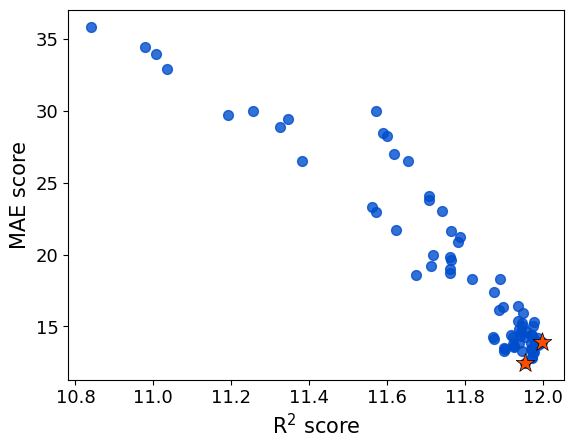

In [10]:
ii = [np.argmax(score_r2), np.argmin(score_mae)]
print(ii)
plt.scatter(score_r2, score_mae, color=[0,0.3,0.8], alpha=0.8, s=50)
plt.scatter(score_r2[ii], score_mae[ii], color=[1,0.3,0], marker='*', s=200, edgecolor=[0,0,0], lw=0.5)

plt.ylabel('MAE score', fontsize=15)
plt.xlabel('R$^2$ score', fontsize=15)
#plt.legend(loc='lower left')

- copy

In [22]:
import shutil
tags = np.array(list(cv_errs.keys()))
ii = [np.argmax(score_r2), np.argmin(score_mae)]
print(ii, tags[ii])
for i in ii:
    tag = tags[i]
    t = tag.split('_')
    net = t[0]
    dim = '_'.join(t[1:-1])
    path1 = f'/home/jhyang/WORKSPACES/MODELS/fpoly/r100/encoders_cs/{net}/{dim}'
    path2 = f'../outputs/pretrain/{dim}'
    for i in range(5):
        path3 = os.path.join(path1, f'cv_{i:04d}')
        os.makedirs(os.path.join(path2, f'fold_{i:02d}'), exist_ok=True)
        fns = [f for f in os.listdir(path3) if f.startswith('events.out.tfevents')] + ['scale.json','param.json','00500.model.torch','00500.train.pkl','00500.valid.pkl','00500.test.pkl']
        for fn in fns:
            shutil.copy(os.path.join(path3, fn),
                        os.path.join(path2, f'fold_{i:02d}', fn.replace('00500.','')))
#            print(os.path.join(path3, fn), os.path.join(path2, f'fold_{i:02d}', fn.replace('00500.','')))
    fns = [f for f in os.listdir(path1) if f.startswith('events.out.tfevents')] + ['scale.json','param.json','00500.model.torch','00500.train.pkl','00500.test.pkl']
    for fn in fns:
        shutil.copy(os.path.join(path1, fn),
                    os.path.join(path2, fn.replace('00500.','')))
#        print(os.path.join(path1, fn), os.path.join(path2, fn.replace('00500.','')))


[64, 70] ['concat_cg_64.128_6.2_195072' 'concat_cg_64.256_4.2_314624']


- visualization

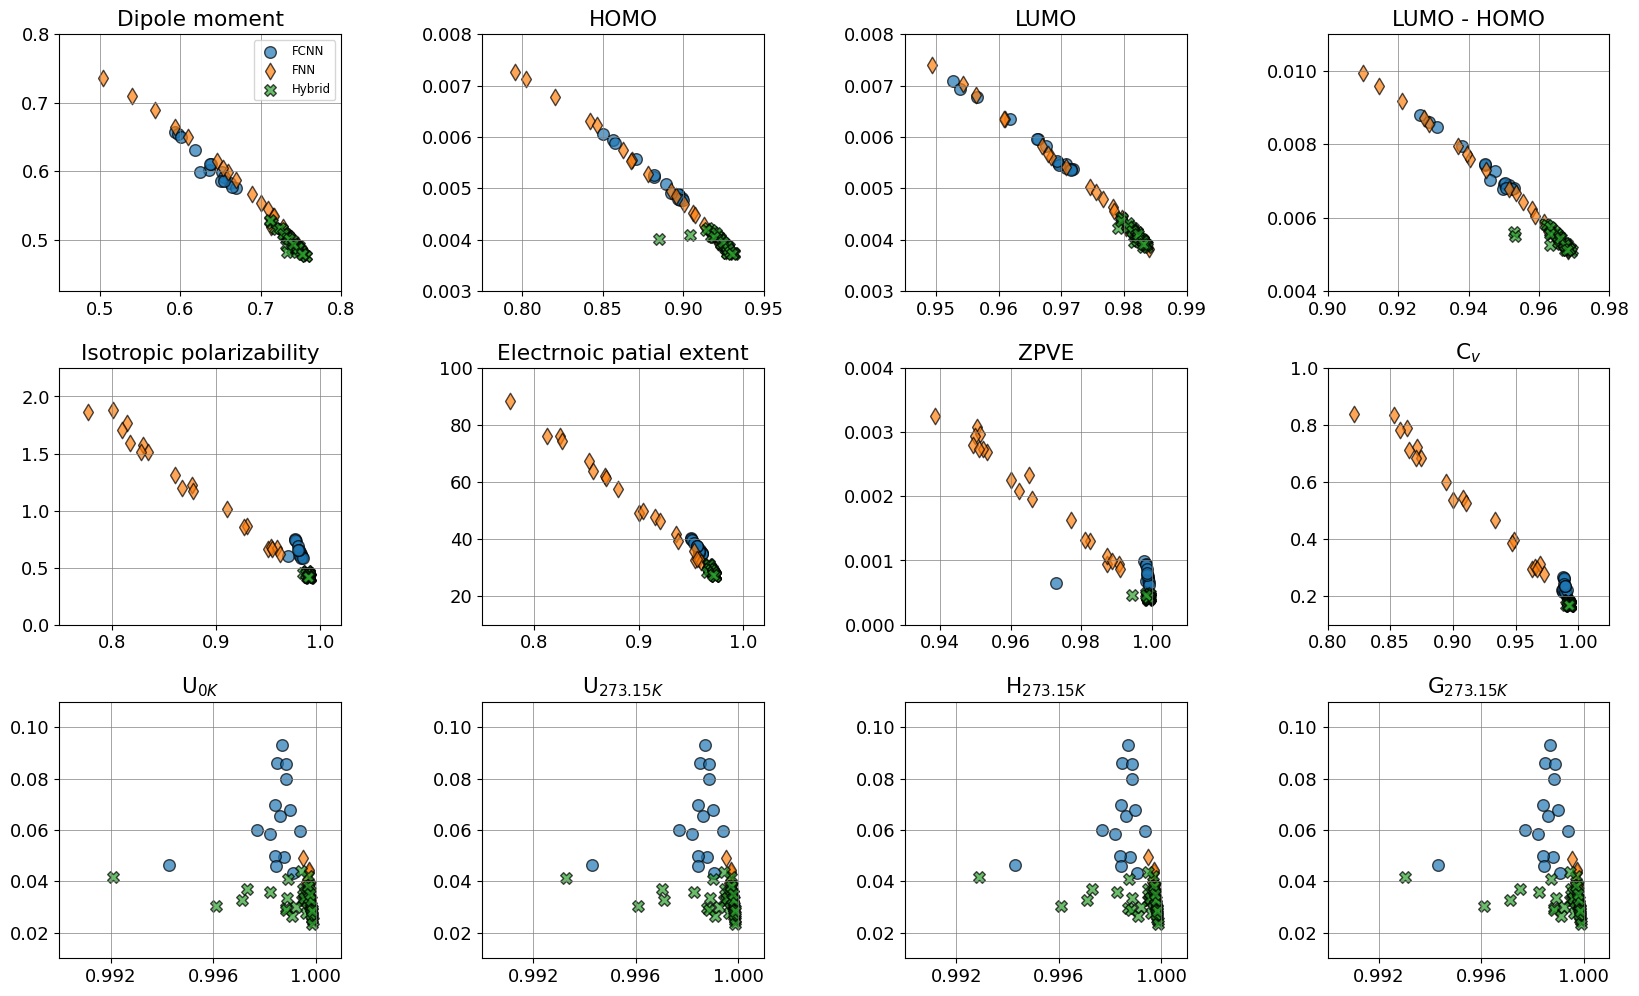

In [164]:
f, axs = plt.subplots(3,4,figsize=(20,12))
xlbls = ["Dipole moment","Isotropic polarizability","HOMO","LUMO","LUMO - HOMO","Electrnoic patial extent","ZPVE","C$_v$","U$_{0K}$","U$_{273.15K}$","H$_{273.15K}$","G$_{273.15K}$"]
order = [0,2,3,4,1,5,6,7,8,9,10,11]
labels = {'mol':'FCNN','graph':'FNN','concat':'Hybrid'}
marker = {'mol':'o','graph':'d','concat':'X'}

for g in ['mol','graph','concat']:
    xs = np.mean([v['valid']['r2'] for k,v in cv_errs.items() if g in k], 1).T
    ys = np.mean([v['valid']['mae'] for k,v in cv_errs.items() if g in k], 1).T
    for i, ax in zip(order, axs.reshape(-1)):
        ax.scatter(xs[i], ys[i], label=labels[g], marker=marker[g], s=70, alpha=0.7, edgecolors=[0,0,0])
        ax.set_title(xlbls[i])
axs[0,0].legend(loc='upper right', fontsize=8.5)
lims = [
    [[0.45, 0.8], [0.425, 0.8], None, None],
    [[0.775, 0.95], [0.003, 0.008], None, [0.003+i*0.001 for i in range(6)]],
    [[0.945, 0.99], [0.003, 0.008], None, [0.003+i*0.001 for i in range(6)]],
    [[0.9, 0.98], [0.004, 0.011], None, [0.004+i*0.002 for i in range(4)]],
    
    [[0.75, 1.02], [0, 2.25], [0.8+i*0.1 for i in range(3)], None],
    [[0.75, 1.02], [10, 100], [0.8+i*0.1 for i in range(3)], [20+i*20 for i in range(5)]],
    [[0.93, 1.01], [0, 0.004], None, [0+i*0.001 for i in range(5)]],
    [[0.8, 1.025], [0.1, 1.0], None, [0.2+i*0.2 for i in range(5)]],
    
    [[0.990, 1.001], [0.01, 0.11], [0.992 + 0.004*i for i in range(3)], None],
    [[0.990, 1.001], [0.01, 0.11], [0.992 + 0.004*i for i in range(3)], None],

    [[0.990, 1.001], [0.01, 0.11], [0.992 + 0.004*i for i in range(3)], None],
    [[0.990, 1.001], [0.01, 0.11], [0.992 + 0.004*i for i in range(3)], None],
]
for ax, (xlim, ylim, xticks, yticks) in zip(axs.reshape(-1), lims):
    ax.set_xlim(xlim)
    if xticks is not None: ax.set_xticks(xticks)
    ax.set_ylim(ylim)
    if yticks is not None: ax.set_yticks(yticks)
    ax.grid('on', color=[0.5,0.5,0.5], lw=0.5)
f.subplots_adjust(hspace=0.3, wspace=0.5)
#f.savefig('./figs/output.pretrain.all.pdf')